In [2]:
setwd("/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts")
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(library(sva))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(beaveR))

In [2]:
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/SYNAPSE_METADATA_MANIFEST.tsv")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"

In [3]:
suppressPackageStartupMessages(library(dplyr))
tissuesOfInt <- c("cerebellum", "medial dorsal nucleus of thalamus")
metaData <- metaData %>% 
    filter(tissue %in% tissuesOfInt)
dim(metaData)[1] == 10
samples <- sapply(strsplit(metaData[["path"]],"/", fixed = T), function(x) 
        sapply(strsplit(x[[length(x)]], ".", fixed = T), function(x) x[1]))
files <- file.path(quantDir, samples, "quant.sf")
all(file.exists(files))
colData <- data.frame(files = files, names = samples, tissue = as.factor(metaData[["tissue"]]))
clustFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100//nothr0//cluster_nwk.txt"
tseChimp <- buildTSE(treeTermFile = clustFile, coldata = colData)

[1] TRUE

[1] TRUE

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


couldn't find matching transcriptome, returning non-ranged SummarizedExperiment

Missing txps 4752

Aggregation Started

Aggregation Ended



In [6]:
suppressPackageStartupMessages(library(GenomicFeatures))
tree <- rowTree(tseChimp)
nleaves <- length(tree$tip)
txdb <- makeTxDbFromGFF(file="/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/Pan_troglodytes.Pan_tro_3.0.104.gtf.gz")
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")
tnames <- sapply(strsplit(rownames(tseChimp)[1:nleaves], split=".", fixed=T), function(x) x[1])
names(tnames) <- rownames(tseChimp)[1:l]

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK

'select()' returned 1:1 mapping between keys and columns



In [30]:
rData <- tx2gene[match(tnames[rownames(tseChimp)[1:nleaves]], tx2gene[,"TXNAME"]),]
rData <- rbind(rData, data.frame("TXNAME"=rownames(tseChimp)[(nleaves+1):nrow(tseChimp)], 
                                 "GENEID" = as.character(sapply(desc, length))))
desc <- lapply(lapply(Descendants(tree, (nleaves+1):nrow(tseChimp)), function(nodes) rownames(tseChimp)[nodes]), function(txps) {
  tx2gene[match(tnames[txps], tx2gene[,"TXNAME"]), "GENEID"]  
})
rowData(tseChimp) <- rData

In [31]:
saveDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts/environment/Chimp/DE"
save(tseChimp, file = file.path(saveDir, "tseChimp.RData"))

using counts and average transcript lengths from tximeta

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



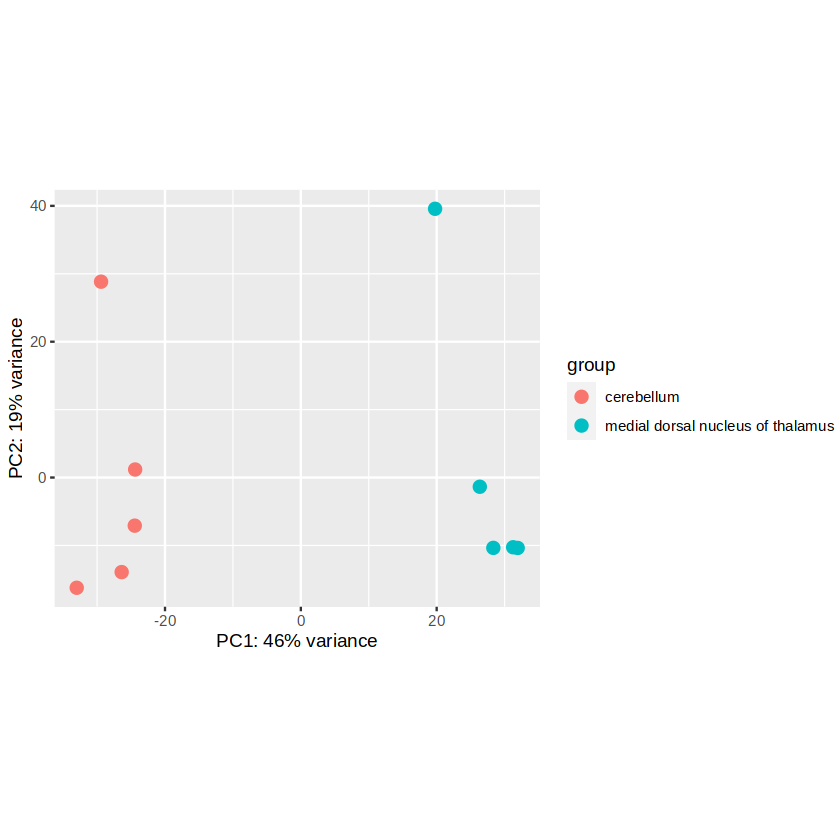

In [5]:
dds <- DESeqDataSet(tseChimp[1:nleaves,], design=~tissue)
dds <- estimateSizeFactors(dds)
dds <- dds[rowSums(assays(dds)[["counts"]]) > 10,]
vsd <- vst(dds)
plotPCA(vsd, intgroup=c("tissue"), ntop=1000)

In [32]:
y <- fishpond::scaleInfReps(tseChimp[1:nleaves,])

In [33]:
infRepIdx <- grep("infRep",assayNames(y),value=TRUE)
nreps <- length(infRepIdx)

mm <- model.matrix(~tissue, colData(dds))
mm0 <- model.matrix(~ 1, colData(dds))
norm.cts <- counts(dds, normalized=TRUE)
norm.cts <- norm.cts[rowSums(norm.cts) > 0,]

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5   [1] 6.164971e-01 1.433204e-01 8.528966e-02 4.308629e-02 3.997626e-02
 [6] 3.171040e-02 1.861200e-02 1.409744e-02 7.410485e-03 4.446791e-32
Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5   [1] 6.377240e-01 1.415755e-01 8.560042e-02 4.299995e-02 3.744960e-02
 [6] 2.209903e-02 1.589117e-02 1.032013e-02 6.340259e-03 4.719067e-32


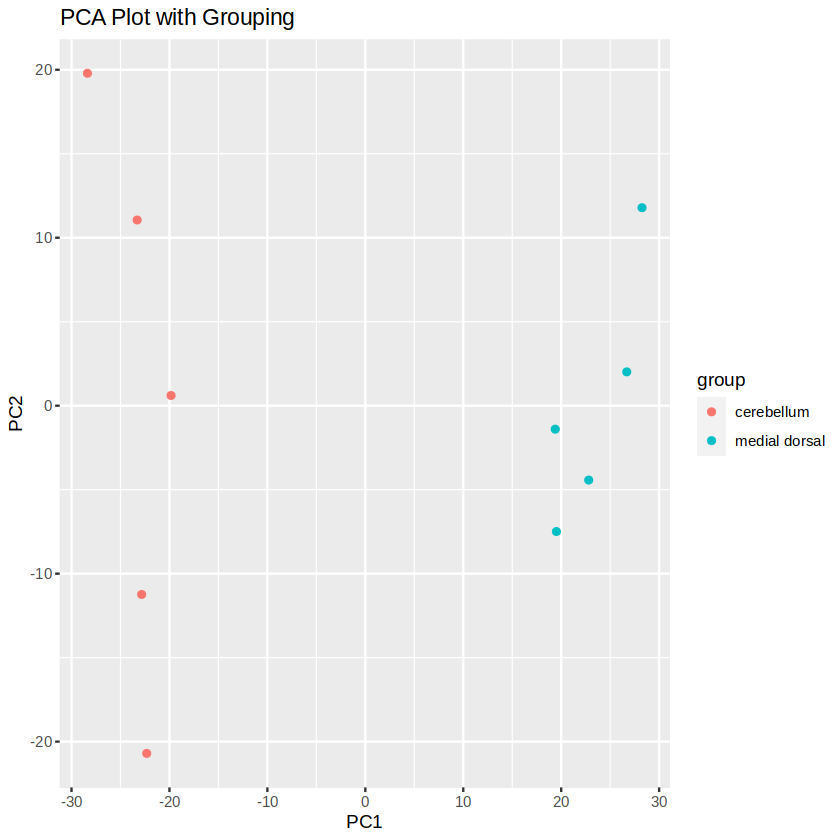

Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5   [1] 6.809440e-01 1.412906e-01 6.037534e-02 4.533721e-02 2.582442e-02
 [6] 1.540476e-02 1.381199e-02 9.847539e-03 7.164160e-03 3.948849e-32


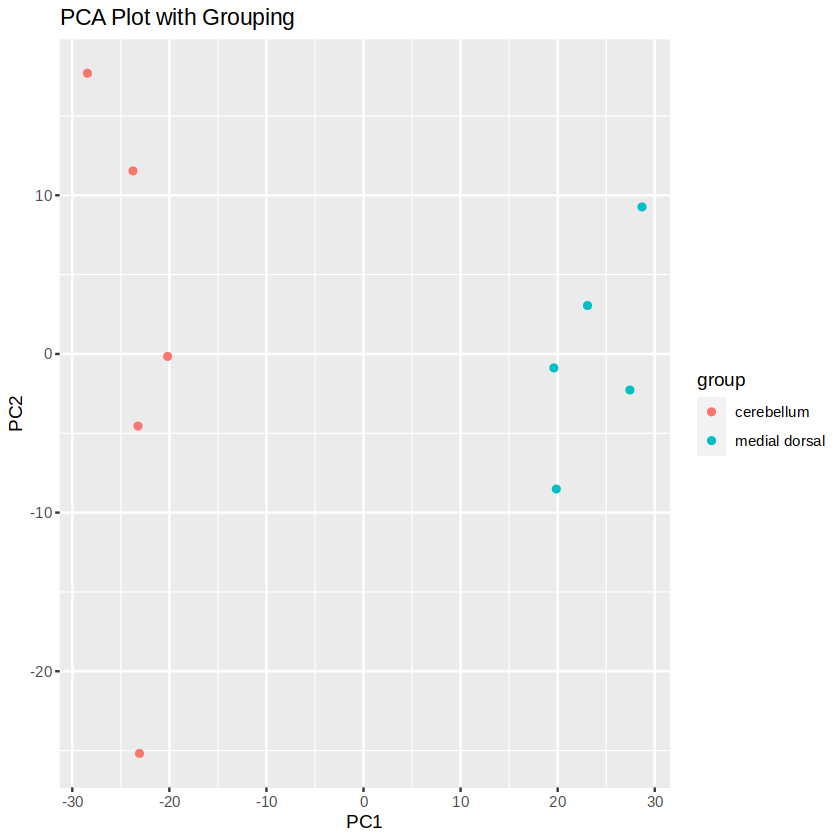

Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5   [1] 7.781868e-01 9.382790e-02 6.250687e-02 3.077026e-02 1.767722e-02
 [6] 9.590588e-03 7.427609e-03 1.181437e-05 9.315282e-07 4.053689e-32


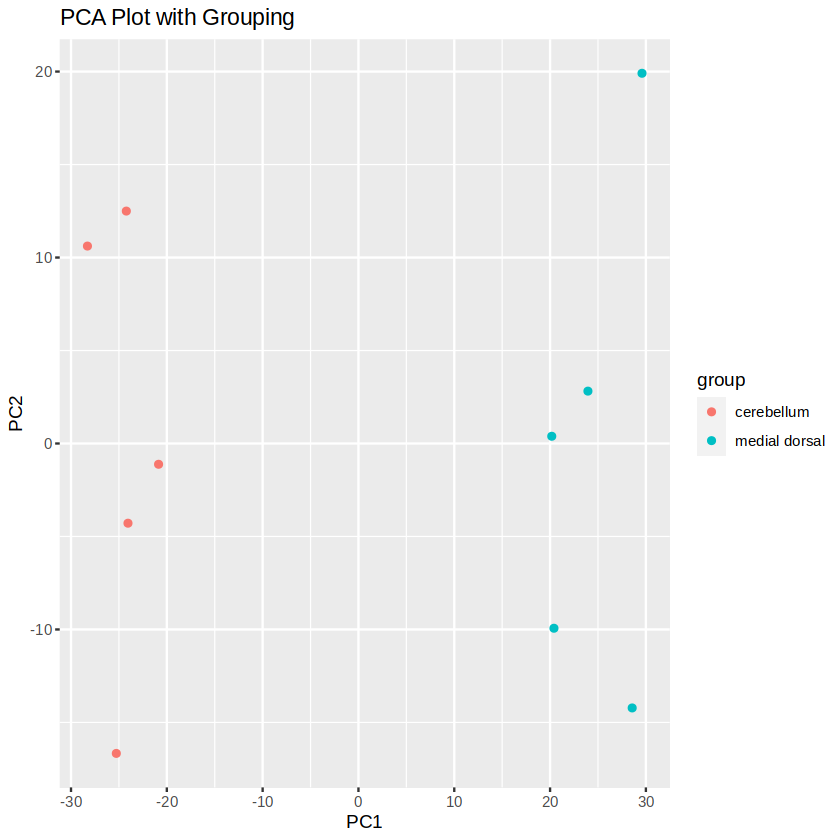

Number of significant surrogate variables is:  6 
Iteration (out of 5 ):1  2  3  4  5   [1] 8.649573e-01 7.615906e-02 3.749733e-02 1.095065e-02 1.042460e-02
 [6] 8.527645e-06 1.986483e-06 3.316610e-07 2.336853e-07 3.824892e-32


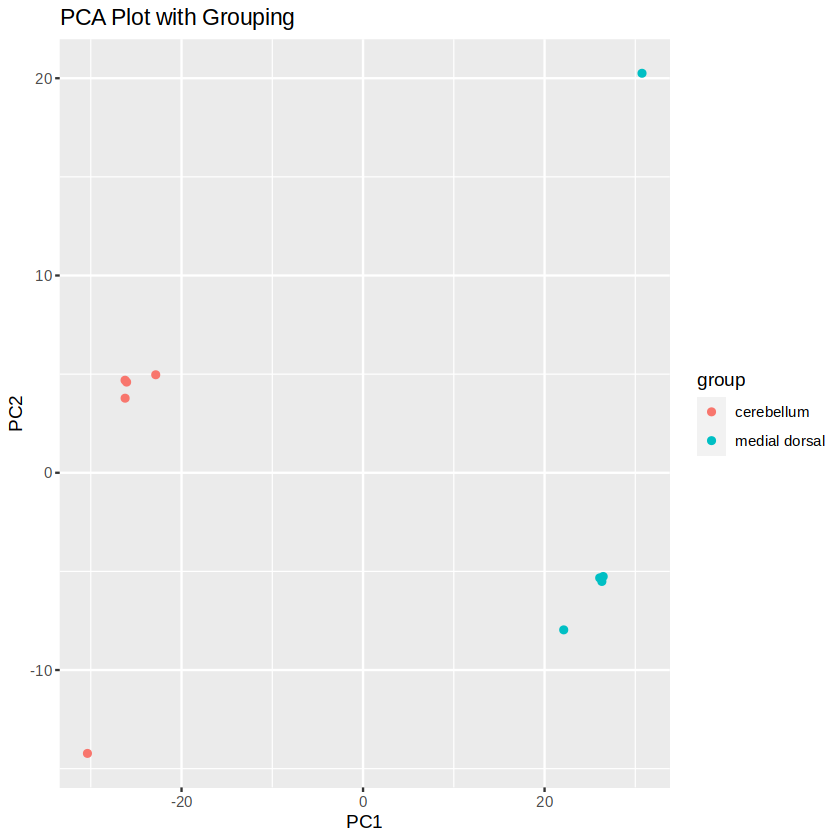

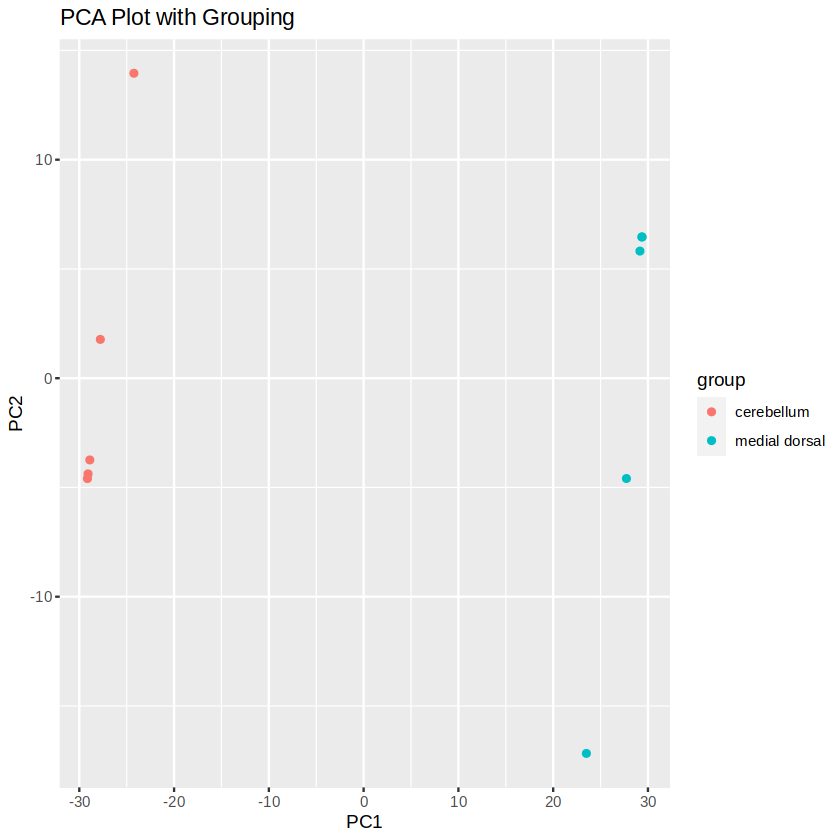

In [34]:
for(sv in c(2:6)) {
        fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=sv)
        pc <- .1
        yo <- y
        for (k in seq_len(nreps)) {
            logInfRep <- log(assay(yo, infRepIdx[k]) + pc)
            logInfRep <- limma::removeBatchEffect(
              logInfRep,
              covariates=fit[["sv"]],
              design=mm)
              assay(yo, infRepIdx[k]) <- exp(logInfRep)
        }
        
        top <- order(rowVars(assays(yo)[["infRep1"]]), decreasing = T)[1:1000]
        pca <- prcomp(t(assays(yo)[["infRep1"]][top,]), scale. = T)
        
        scores <- data.frame(pca$x[,1:2], group = factor(rep(c("cerebellum", "medial dorsal"), each = 5)),
                    var = pca$sdev^2/sum(pca$sdev^2))

        print(scores[["var"]])
        print(ggplot(scores, aes(x = PC1, y = PC2, color = group)) +
          geom_point() +
          xlab("PC1") +
          ylab("PC2") +
          ggtitle("PCA Plot with Grouping"))
}


#### Correcting batch effects using sv = 2

In [35]:
fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=2)
for (k in seq_len(nreps)) {
    logInfRep <- log(assay(y, infRepIdx[k]) + pc)
    logInfRep <- limma::removeBatchEffect(
      logInfRep,
      covariates=fit[["sv"]],
      design=mm)
      assay(y, infRepIdx[k]) <- exp(logInfRep)
}


Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

 [1] 6.164971e-01 1.433204e-01 8.528966e-02 4.308629e-02 3.997626e-02
 [6] 3.171040e-02 1.861200e-02 1.409744e-02 7.410485e-03 4.446791e-32


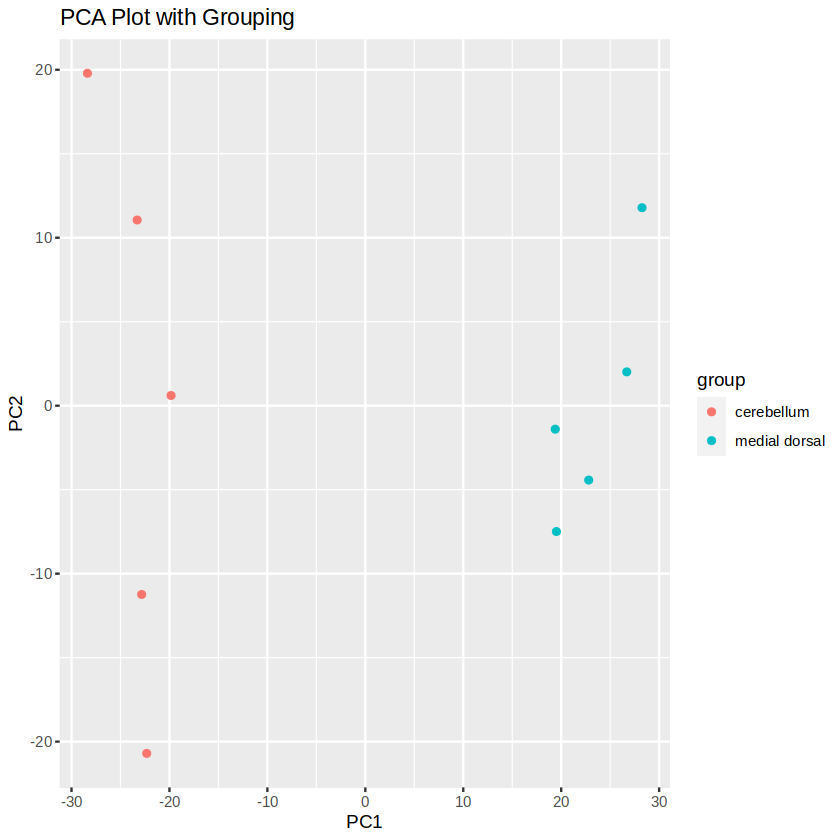

In [36]:
top <- order(rowVars(assays(y)[["infRep1"]]), decreasing = T)[1:1000]
pca <- prcomp(t(assays(y)[["infRep1"]][top,]), scale. = T)
        
scores <- data.frame(pca$x[,1:2], group = factor(rep(c("cerebellum", "medial dorsal"), each = 5)),
            var = pca$sdev^2/sum(pca$sdev^2))

print(scores[["var"]])
print(ggplot(scores, aes(x = PC1, y = PC2, color = group)) +
  geom_point() +
  xlab("PC1") +
  ylab("PC2") +
  ggtitle("PCA Plot with Grouping"))

In [37]:
y <- labelKeep(y)
set.seed(10)
y <- swish(y, x="tissue")
sum(mcols(y)[["pvalue"]] < 0.1, na.rm=T)
save(y, file=file.path(saveDir, "y.RData"))

[1] 13831

In [19]:
tseChimp <- computeInfRV(tseChimp)
yAll <- computeSizeFactors(tseChimp)
yAll <- scaleInfReps(yAll)

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [24]:
fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=2)
pc <- .1

for (k in seq_len(nreps)) {
    logInfRep <- log(assay(yAll, infRepIdx[k]) + pc)
    logInfRep <- limma::removeBatchEffect(
      logInfRep,
      covariates=fit[["sv"]],
      design=mm)
      assay(yAll, infRepIdx[k]) <- exp(logInfRep)
}
        

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

#### Run Swish

In [25]:
yAll <- labelKeep(yAll)
set.seed(10)
yAll <- swish(yAll, x = "tissue")
save(yAll, file=file.path(saveDir, "yAll.RData"))

### Gene Level

In [30]:
load("environment/Chimp/se_chimp.RData")
gy <- summarizeToGene(seChimp)

useHub=TRUE: checking for EnsDb via 'AnnotationHub'

snapshotDate(): 2021-05-18

did not find matching EnsDb via 'AnnotationHub'

building EnsDb with 'ensembldb' package

NOTE: linkedTxome with source='Ensembl', ensembldb will be used to parse GTF.
this may produce errors if the GTF is not from Ensembl, or has been modified

Importing GTF file ... 
OK

Processing metadata ... 
OK

Processing genes ... 

 Attribute availability:

  o gene_id ... OK

  o gene_name ... OK

  o entrezid ... Nope

  o gene_biotype ... OK

OK

Processing transcripts ... 

 Attribute availability:

  o transcript_id ... OK

  o gene_id ... OK

  o transcript_biotype ... OK

OK

Processing exons ... 
OK

Processing chromosomes ... 
Fetch seqlengths from ensembl ... 
OK

Generating index ... 
OK

  -------------

Verifying validity of the information in the database:

Checking transcripts ... 
OK
Checking exons ... 
OK

obtaining transcript-to-gene mapping from database

generating gene ranges

summarizing abun

In [46]:
gy <- fishpond::scaleInfReps(gy)
gy <- labelKeep(gy)
gy <- gy[mcols(gy)$keep,]
gy <- gy[,colnames(tseChimp)]
colData(gy)[["tissue"]] <- as.factor(colData(gy)[["tissue"]])
set.seed(10)
gy <- swish(gy, x="tissue")
save(gy, file = file.path(saveDir, "gy.RData"))

In [49]:
gy

class: RangedSummarizedExperiment 
dim: 15438 10 
metadata(8): tximetaInfo quantInfo ... infRepsScaled preprocessed
assays(103): counts abundance ... infRep99 infRep100
rownames(15438): ENSPTRG00000000001 ENSPTRG00000000008 ...
  ENSPTRG00000054602 ENSPTRG00000054624
rowData names(14): gene_id gene_name ... locfdr qvalue
colnames(10): PTB162LCBC PTB167RCBC ... PTB167RMD PTB166RMD
colData names(26): names path ... resourceType condition

In [51]:
sum(mcols(gy)[["qvalue"]] < 0.1, na.rm=T)

[1] 7331